In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import random
import requests

# get data and categorise

In [7]:
# download the data

# train_set_url ="https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip"
# validation_set_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip"
# save_to = "data/rock-paper-sissor/"

# os.mkdir(save_to)

# def download_data(url, path=""):
#     file_name = url.split("/")[-1]
#     with requests.get(url, stream=True) as data:
#         data.raise_for_status()
#         with open(path+file_name, "wb") as f:
#             for chunk in data.iter_content(chunk_size=8192):
#                 # If you have chunk encoded response set chunk_size parameter to None 
#                 # and uncomment below if statement
#                 #if chunk:
#                 f.write(chunk)
#     print(f"downloaded {file_name}")
#     return "exit code 0"

# download_data(train_set_url, save_to)
# download_data(validation_set_url, save_to)

downloaded rps.zip
downloaded rps-test-set.zip


'exit code 0'

In [9]:
# set directories and 

# for zipped in os.listdir(save_to):
#     os.mkdir(save_to+zipped.split(".")[0])
#     with zipfile.ZipFile(save_to+zipped.split(".")[0]) as zipref:
#         zipref.extractall(save_to)
#     os.remove(save_to+zipped)
    
# os.rename(save_to+"rps", save_to+"train")
# os.rename(save_to+"rps-test-set", save_to+"validation")

In [15]:
# we also have some images for predictions
# test_set_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-validation.zip"
# download_data(test_set_url, save_to)
# # os.mkdir(save_to+"rps-validation")
# with zipfile.ZipFile(save_to+"rps-validation", "r") as zipref:
#     zipref.extractall(member="rps-validation.zip")
# os.remove(save_to+"rps-validation.zip")
# os.rename(save_to+"rps-validation", save_to+"test")

Text(0.5, 1.0, 'scissor')

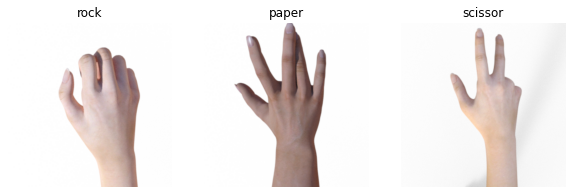

In [7]:
# visualise some of the images

img1 = mpimg.imread(f"data/rock-paper-sissor/train/rock/{os.listdir('data/rock-paper-sissor/train/rock/')[0]}")
img2 = mpimg.imread(f"data/rock-paper-sissor/train/paper/{os.listdir('data/rock-paper-sissor/train/paper/')[0]}")
img3 = mpimg.imread(f"data/rock-paper-sissor/train/scissors/{os.listdir('data/rock-paper-sissor/train/scissors/')[0]}")

fig, axs = plt.subplots(1,3, figsize=[10,10])
axs[0].imshow(img1)
axs[0].axis("off")
axs[0].set_title("rock")
axs[1].imshow(img2)
axs[1].axis("off")
axs[1].set_title("paper")
axs[2].imshow(img3)
axs[2].axis("off")
axs[2].set_title("scissor")


In [9]:
# create test and train generators
train_dir = "data/rock-paper-sissor/train/"
validation_dir = "data/rock-paper-sissor/validation/"


training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(train_dir, batch_size=126, class_mode='categorical', target_size=(150, 150))   
validation_generator = validation_datagen.flow_from_directory(validation_dir, batch_size=126, class_mode='categorical', target_size=(150, 150))                                

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [12]:
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [17]:
# create a callback based on accuracy

class AccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95): 
      print("\nReached 95% accuracy. Cancelling training!")
      self.model.stop_training = True

# create a callback to save model weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="data/modelCheckpoints/rock-paper-sissor/", save_weights_only=True, verbose=1)

In [18]:
# history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3, callbacks=[AccuracyCallback(), checkpoint_callback])

Epoch 1/25
20/20 [==============================] - 44s 2s/step - loss: 0.3315 - accuracy: 0.8702 - val_loss: 0.0695 - val_accuracy: 1.0000

Epoch 00001: saving model to data/modelCheckpoints/rock-paper-sissor\
Epoch 2/25
20/20 [==============================] - 41s 2s/step - loss: 0.2788 - accuracy: 0.8893 - val_loss: 0.4806 - val_accuracy: 0.7473

Epoch 00002: saving model to data/modelCheckpoints/rock-paper-sissor\
Epoch 3/25
20/20 [==============================] - 42s 2s/step - loss: 0.2894 - accuracy: 0.8909 - val_loss: 0.0589 - val_accuracy: 0.9919

Epoch 00003: saving model to data/modelCheckpoints/rock-paper-sissor\
Epoch 4/25
20/20 [==============================] - 47s 2s/step - loss: 0.1877 - accuracy: 0.9361 - val_loss: 0.0455 - val_accuracy: 1.0000

Epoch 00004: saving model to data/modelCheckpoints/rock-paper-sissor\
Epoch 5/25
20/20 [==============================] - 44s 2s/step - loss: 0.2114 - accuracy: 0.9183 - val_loss: 0.5144 - val_accuracy: 0.7285

Epoch 00005: sa

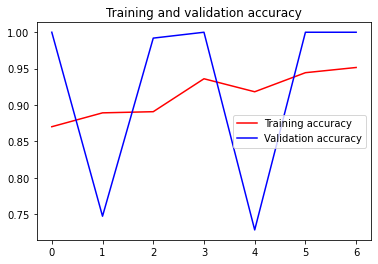

<Figure size 432x288 with 0 Axes>

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()